<a href="https://colab.research.google.com/github/HadisZare12/Rainfall_Prediction_RF/blob/main/RainFall_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Workflow
Data Collection -> EDA -> Data Preprocessing -> Train/Test Split -> Random Forest Classifier -> Hyperparameter Tuning

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import pickle


In [32]:
data = pd.read_csv('Rainfall.csv')
data.shape
data.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1,1025.9,19.9,18.3,16.8,13.1,72,49,yes,9.3,80.0,26.3
1,2,1022.0,21.7,18.9,17.2,15.6,81,83,yes,0.6,50.0,15.3
2,3,1019.7,20.3,19.3,18.0,18.4,95,91,yes,0.0,40.0,14.2
3,4,1018.9,22.3,20.6,19.1,18.8,90,88,yes,1.0,50.0,16.9
4,5,1015.9,21.3,20.7,20.2,19.9,95,81,yes,0.0,40.0,13.7


In [33]:
#remove extra spaces in all cols
data.columns = data.columns.str.strip()
data.columns

Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'rainfall', 'sunshine', 'winddirection',
       'windspeed'],
      dtype='object')

In [34]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            366 non-null    int64  
 1   pressure       366 non-null    float64
 2   maxtemp        366 non-null    float64
 3   temparature    366 non-null    float64
 4   mintemp        366 non-null    float64
 5   dewpoint       366 non-null    float64
 6   humidity       366 non-null    int64  
 7   cloud          366 non-null    int64  
 8   rainfall       366 non-null    object 
 9   sunshine       366 non-null    float64
 10  winddirection  365 non-null    float64
 11  windspeed      365 non-null    float64
dtypes: float64(8), int64(3), object(1)
memory usage: 34.4+ KB


In [35]:
data = data.drop(columns=['day']) # not necessary for prediction

In [36]:
data.head()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1025.9,19.9,18.3,16.8,13.1,72,49,yes,9.3,80.0,26.3
1,1022.0,21.7,18.9,17.2,15.6,81,83,yes,0.6,50.0,15.3
2,1019.7,20.3,19.3,18.0,18.4,95,91,yes,0.0,40.0,14.2
3,1018.9,22.3,20.6,19.1,18.8,90,88,yes,1.0,50.0,16.9
4,1015.9,21.3,20.7,20.2,19.9,95,81,yes,0.0,40.0,13.7


In [37]:
data.isnull().sum()

,0
pressure,0
maxtemp,0
temparature,0
mintemp,0
dewpoint,0
humidity,0
cloud,0
rainfall,0
sunshine,0
winddirection,1


In [38]:
#handle missing values
data["winddirection"] = data["winddirection"].fillna(data["winddirection"].mode()[0])
data["windspeed"] = data["windspeed"].fillna(data["windspeed"].median())
data.isnull().sum()

,0
pressure,0
maxtemp,0
temparature,0
mintemp,0
dewpoint,0
humidity,0
cloud,0
rainfall,0
sunshine,0
winddirection,0


In [39]:
data["rainfall"].unique()

array(['yes', 'no'], dtype=object)

In [40]:
#convert object value to numeric
data["rainfall"] = data["rainfall"].map({"yes": 1, "no": 0})
data.head()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1025.9,19.9,18.3,16.8,13.1,72,49,1,9.3,80.0,26.3
1,1022.0,21.7,18.9,17.2,15.6,81,83,1,0.6,50.0,15.3
2,1019.7,20.3,19.3,18.0,18.4,95,91,1,0.0,40.0,14.2
3,1018.9,22.3,20.6,19.1,18.8,90,88,1,1.0,50.0,16.9
4,1015.9,21.3,20.7,20.2,19.9,95,81,1,0.0,40.0,13.7


In [41]:
#Exploratory Data Analysis (EDA)
#setting plot style
sns.set(style='whitegrid')


In [42]:
data.describe()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,1013.742623,26.191257,23.747268,21.894536,19.989071,80.177596,71.128415,0.680328,4.419399,101.284153,21.534153
std,6.414776,5.978343,5.632813,5.594153,5.997021,10.062470,21.798012,0.466988,3.934398,81.722827,10.056054
min,998.500000,7.100000,4.900000,3.100000,-0.400000,36.000000,0.000000,0.000000,0.000000,10.000000,4.400000
25%,1008.500000,21.200000,18.825000,17.125000,16.125000,75.000000,58.000000,0.000000,0.500000,40.000000,13.725000
50%,1013.000000,27.750000,25.450000,23.700000,21.950000,80.500000,80.000000,1.000000,3.500000,70.000000,20.500000
75%,1018.100000,31.200000,28.600000,26.575000,25.000000,87.000000,88.000000,1.000000,8.200000,190.000000,27.825000
max,1034.600000,36.300000,32.400000,30.000000,26.700000,98.000000,100.000000,1.000000,12.100000,350.000000,59.500000


In [43]:
data.columns


Index(['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity',
       'cloud', 'rainfall', 'sunshine', 'winddirection', 'windspeed'],
      dtype='object')

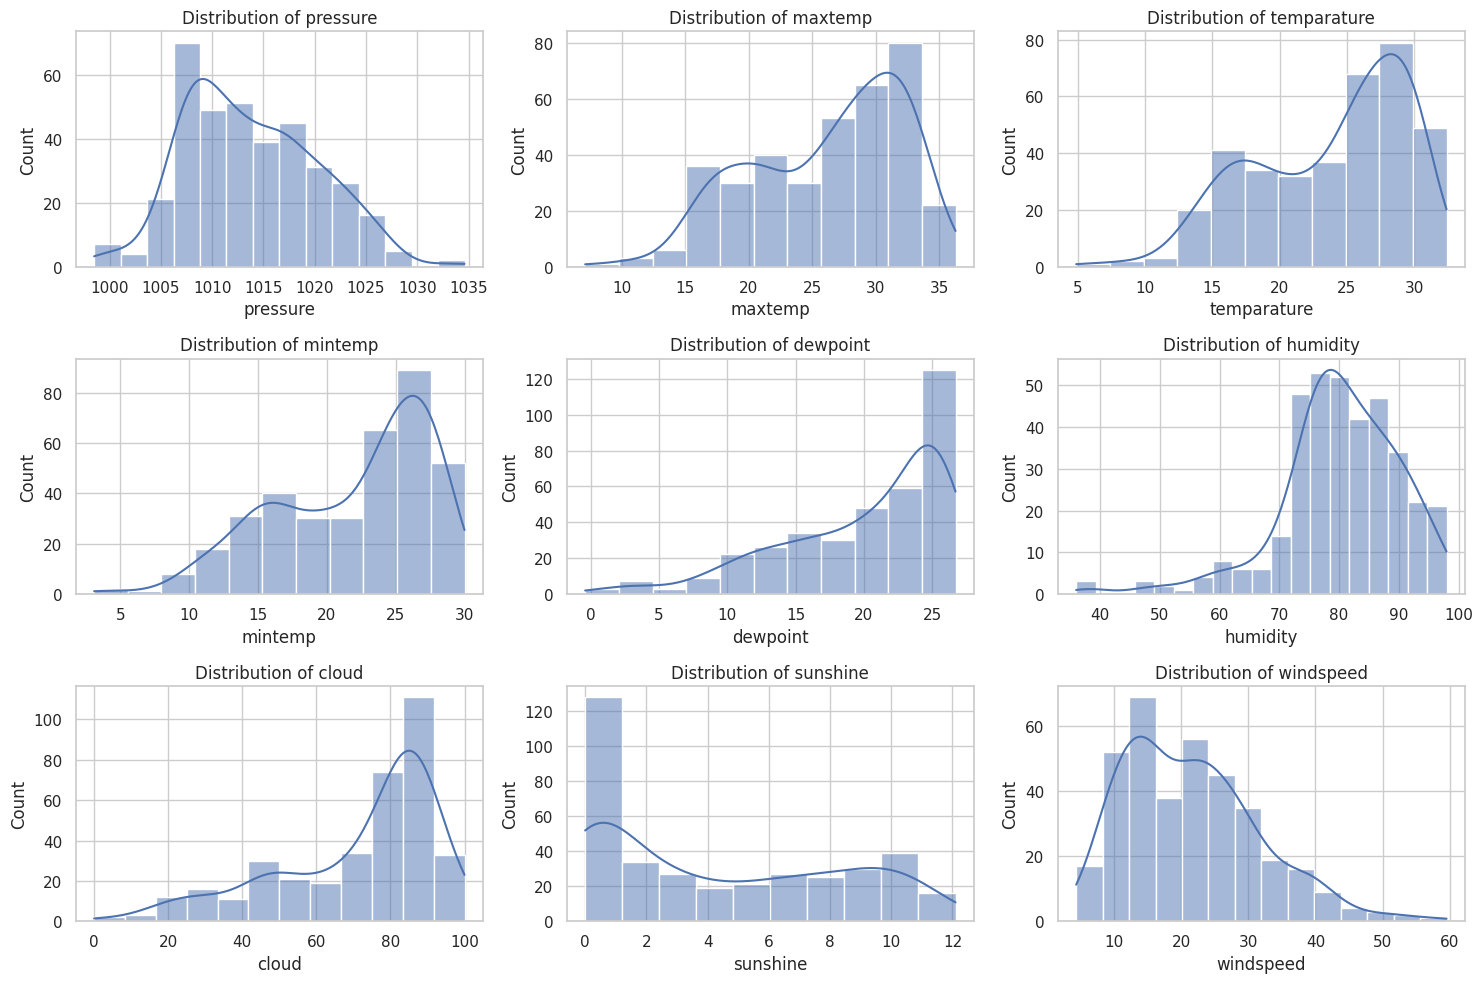

In [44]:
plt.figure(figsize=(15,10))
for i,col in enumerate(['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity',
       'cloud', 'sunshine', 'windspeed'],1):
  plt.subplot(3,3,i)
  sns.histplot(data[col],kde=True)
  plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


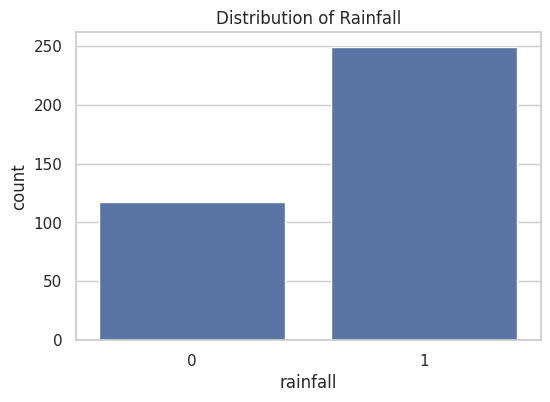

In [45]:
plt.figure(figsize=(6,4))
sns.countplot(x='rainfall',data=data)
plt.title('Distribution of Rainfall')
plt.show()

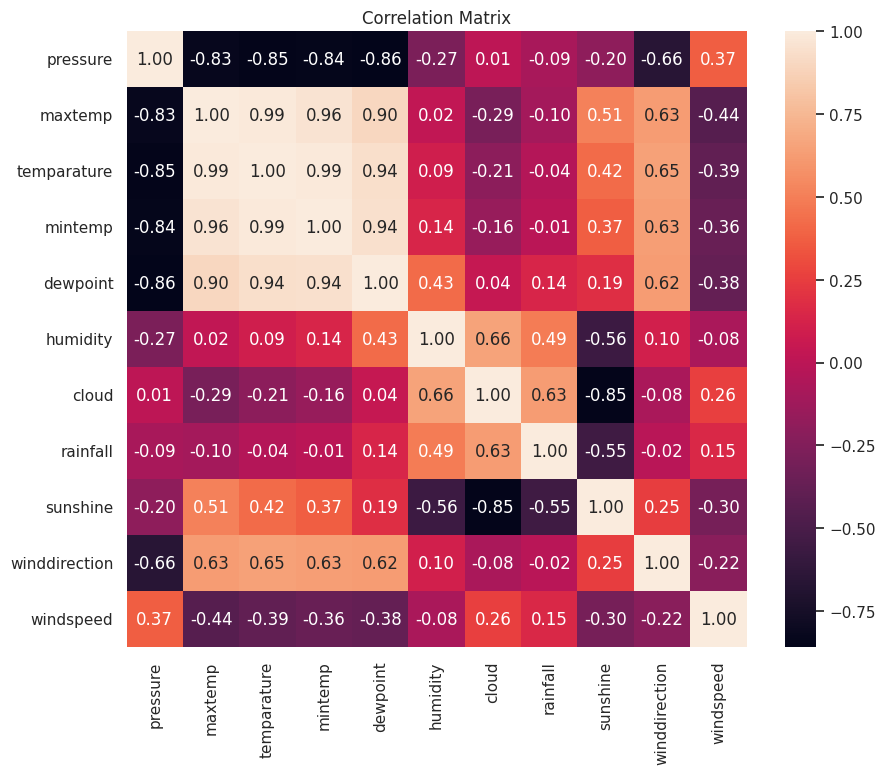

In [46]:
#correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(),annot=True,fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

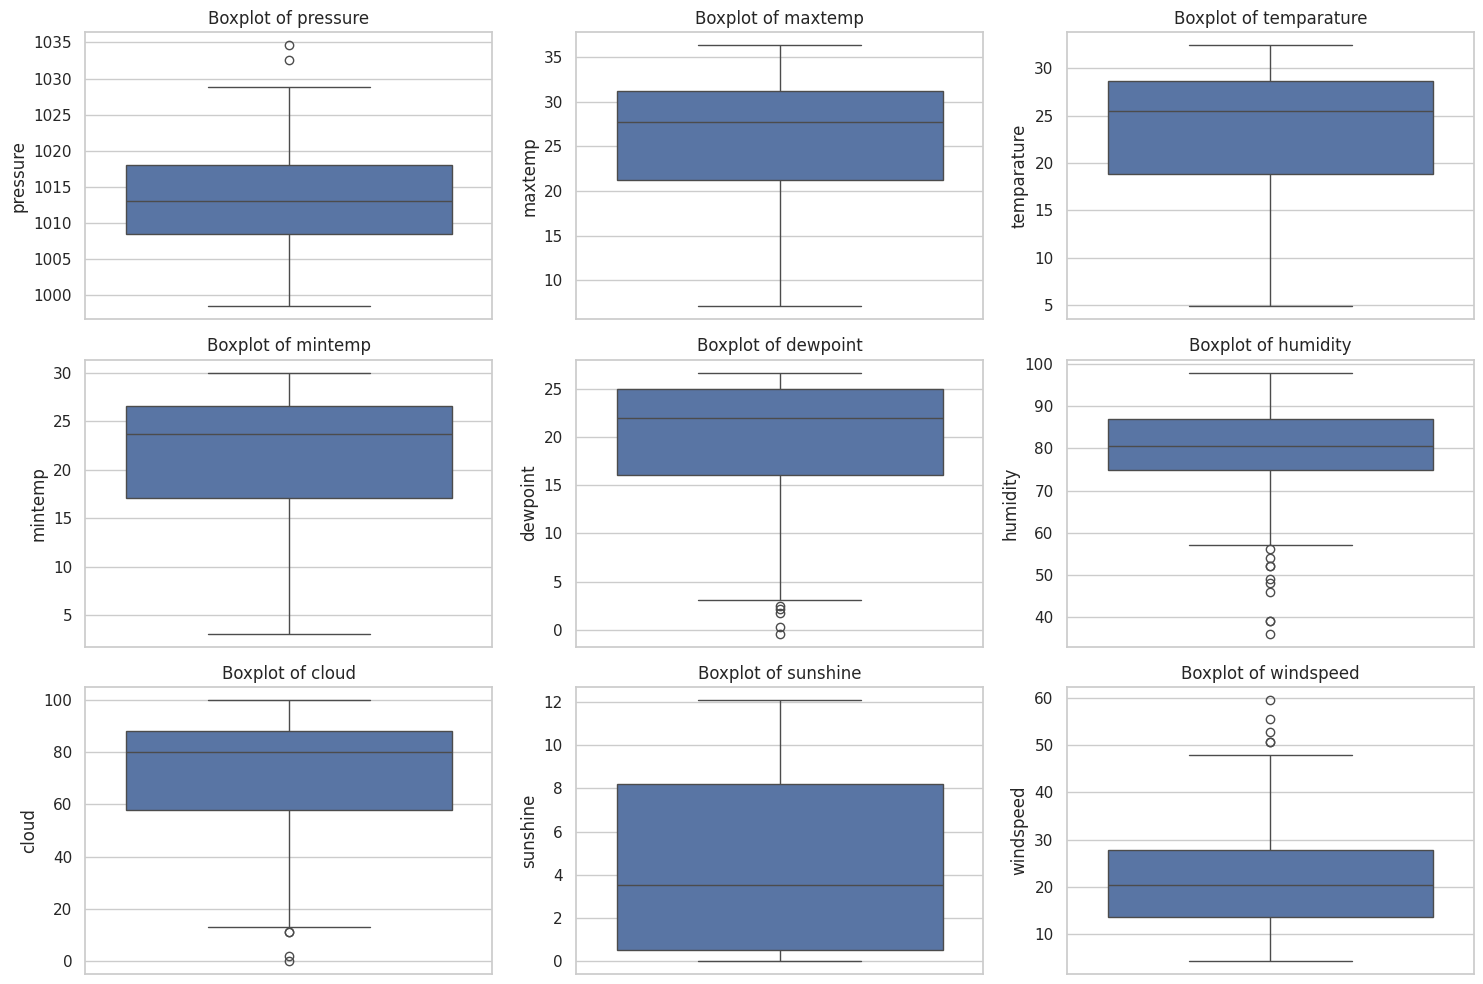

In [47]:
plt.figure(figsize=(15,10))
for i,col in enumerate(['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity',
       'cloud', 'sunshine', 'windspeed'],1):
  plt.subplot(3,3,i)
  sns.boxplot(data[col])
  plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [48]:
#from four highly correlated columns , drop 3 of them
data = data.drop(columns=['maxtemp','temparature', 'mintemp'])
data.head()

,pressure,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1025.9,13.1,72,49,1,9.3,80.0,26.3
1,1022.0,15.6,81,83,1,0.6,50.0,15.3
2,1019.7,18.4,95,91,1,0.0,40.0,14.2
3,1018.9,18.8,90,88,1,1.0,50.0,16.9
4,1015.9,19.9,95,81,1,0.0,40.0,13.7


In [49]:
print(data['rainfall'].value_counts())

rainfall
1    249
0    117
Name: count, dtype: int64


In [50]:
# separate majority and minority
df_majority = data[data['rainfall'] == 1]
df_minority = data[data['rainfall'] == 0]


In [51]:
#downsample majority class
df_majority_downsampled = resample(df_majority,
                                  replace=False,
                                  n_samples=len(df_minority),
                                  random_state=42)

In [52]:
df_majority_downsampled.shape

(117, 8)

In [53]:
#concatenate the data
df_downsampled = pd.concat([df_majority_downsampled,df_minority])

In [54]:
df_downsampled.shape

(234, 8)

In [55]:
#shuffle the dataframe
df_downsampled= df_downsampled.sample(frac=1).reset_index(drop=True)
df_downsampled.head()

,pressure,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1000.3,25.0,81,88,1,2.5,240.0,18.8
1,1004.2,26.6,81,88,1,2.4,220.0,30.0
2,1008.9,25.4,77,32,0,11.9,250.0,21.6
3,1005.3,24.2,72,29,0,10.6,220.0,6.1
4,1008.6,20.6,75,62,0,8.8,80.0,26.0


In [60]:
#split the data
X = df_downsampled.drop(columns=['rainfall'])
y = df_downsampled['rainfall']


In [64]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

Model Training


In [58]:
rf_model = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50,100,200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}



In [65]:
#Hyperparameter using GridsearchCV
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1,verbose=2)
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [67]:
best_rf_model = grid_search_rf.best_estimator_
print("Best Random Forest Model:", best_rf_model)

Best Random Forest Model: RandomForestClassifier(min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200, random_state=42)


Model Evaluation

In [68]:
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5)
print("Cross-Validation Scores for Random Forest:", cv_scores)
print("Mean Cross-Validation Score for Random Forest:", cv_scores.mean())

Cross-Validation Scores for Random Forest: [0.76315789 0.84210526 0.78378378 0.91891892 0.7027027 ]
Mean Cross-Validation Score for Random Forest: 0.8021337126600285


In [69]:
#test set performance
y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", accuracy)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

Accuracy on Test Set: 0.7446808510638298
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        21
           1       0.77      0.77      0.77        26

    accuracy                           0.74        47
   macro avg       0.74      0.74      0.74        47
weighted avg       0.74      0.74      0.74        47

[[15  6]
 [ 6 20]]


Prediction on Unknown data

In [70]:
X_train.columns

Index(['pressure', 'dewpoint', 'humidity', 'cloud', 'sunshine',
       'winddirection', 'windspeed'],
      dtype='object')

In [74]:
input_data = (1015.9,19.9,95,81,0.0,40.0,13.7)
input_df = pd.DataFrame([input_data],columns=['pressure', 'dewpoint', 'humidity', 'cloud', 'sunshine',
       'winddirection', 'windspeed'])
print(input_df)
prediction = best_rf_model.predict(input_df)
print('prediction result : ','Rainfall' if prediction[0] == 1 else 'No Rainfall')

   pressure  dewpoint  humidity  cloud  sunshine  winddirection  windspeed
0    1015.9      19.9        95     81       0.0           40.0       13.7
prediction result :  Rainfall


In [77]:
#save and export the model and features
model_data = {'model':best_rf_model,'features':X_train.columns.tolist()}
with open('rainfall_prediction_model.pkl','wb') as file:
  pickle.dump(model_data,file)

Load the model

In [78]:
from ast import mod
import pickle
with open('rainfall_prediction_model.pkl','rb') as file:
  model_data = pickle.load(file)
model_saved = model_data['model']
features = model_data['features']

In [80]:
input_data = (1015.9,19.9,95,81,0.0,40.0,13.7)
input_df = pd.DataFrame([input_data],columns=features)
prediction = best_rf_model.predict(input_df)
print('prediction result : ','Rainfall' if prediction[0] == 1 else 'No Rainfall')

prediction result :  Rainfall
